### Amazon Fashion Persona @qnyue

 0. Import libraries 

In [222]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 5
pd.set_option('display.max_columns', 100)
import io
import requests
import warnings
import csv
np.random.seed(27)
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

In [223]:
##Check your working directory
os.getcwd()

'/home/ec2-user/SageMaker/Temp'

A couple of ways reading the data: 1) from S3 2) from cluster 3) upload csv and read it here

In [224]:
df = pd.read_csv('/home/ec2-user/SageMaker/Temp/Data_Dogfood_Sales_2022.csv', encoding="ISO-8859-1")
df.head(10)

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0
5,6,2022-01-01,Don't recall seeing an ad,734114023,Bezt,Bezt Adult Chicken and Brown Rice Recipe Dry D...,14.22,1,905,M,Phoenix,AZ,85099,33.2765,-112.1872,Married,College graduate,"$100,000 or more",45-54,1
6,7,2022-01-01,Don't recall seeing an ad,352670033,Alpha,"Alpha Probiotics Shredded Blend High Protein, ...",79.31,1,1061,F,Portsmouth,NH,214,43.0059,-71.0132,Married,Some college or trade school,"$100,000 or more",55-64,1
7,8,2022-01-01,Don't recall seeing an ad,957351021,Alpha,Alpha Natural Adult Lamb & Rice Dry Dog Food,25.16,1,1411,F,Chicago,IL,60624,41.8804,-87.7223,Single,Some college or trade school,"$40,000 - $59,999",25-34,1
8,9,2022-01-01,Sponsored Products,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,1552,F,Boulder,CO,80310,40.0878,-105.3735,Married,High school graduate,"$80,000 - $99,999",65+,1
9,10,2022-01-01,Don't recall seeing an ad,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,41.12,1,1699,M,Roanoke,VA,24009,37.2742,-79.9579,Single,Post graduate,"$100,000 or more",45-54,1


In [225]:
df.columns

Index(['sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime'],
      dtype='object')

In [226]:
df.dtypes

sale_id            int64
sale_date         object
ad_exp            object
product_id         int64
product_brand     object
product_name      object
price            float64
qty                int64
customer_id        int64
gender            object
city              object
st                object
zip                int64
lat              float64
lng              float64
marital           object
education         object
income            object
age               object
prime              int64
dtype: object

2. Create additional variables

In [227]:
#additional varaibles
df['ad_exp'].value_counts()

Don't recall seeing an ad    3096
Sponsored Brands             2520
Sponsored Products           2017
Display/banner ad            1297
Video ad                      254
Some other type of ad          31
Name: ad_exp, dtype: int64

In [228]:
df['ad_ind']= np.where(df['ad_exp']=="Don't recall seeing an ad", 0,1)
df['ad_ind'].value_counts()

1    6119
0    3096
Name: ad_ind, dtype: int64

In [229]:
df['marital'].value_counts()

Married                                  4706
Single                                   3663
Domestic partner/serious relationship     846
Name: marital, dtype: int64

In [230]:
df['ma_ind']= np.where(df['marital']=="Single", 0,1)
df['ma_ind'].value_counts()

1    5552
0    3663
Name: ma_ind, dtype: int64

In [231]:
df['education'].value_counts()

College graduate                4101
Some college or trade school    1946
High school graduate            1745
Post graduate                   1423
Name: education, dtype: int64

In [232]:
df['edu_ind']= np.where(df['education']=="High school graduate", 0, np.where(df['education']=="Some college or trade school", 0,1))
df['edu_ind'].value_counts()


1    5524
0    3691
Name: edu_ind, dtype: int64

In [233]:
df['income'].value_counts()

$100,000 or more     2754
$80,000 - $99,999    1537
$60,000 - $79,999    1469
$40,000 - $59,999    1442
$20,000 - $39,999    1426
Less than $20,000     587
Name: income, dtype: int64

In [234]:
def level(row): 
    if row['income'] == "Less than $20,000": 
        return '0'
    elif row['income'] == "$20,000 - $39,999":
        return '1'
    elif row['income'] == "$40,000 - $59,999":
        return '2'
    elif row['income'] == "$60,000 - $79,999":
        return '3'    
    elif row['income'] == "$80,000 - $99,999":
        return '4'  
    elif row['income'] == "$100,000 or more":
        return '5'  
    return 'other' 

In [235]:
df['income_level'] = df.apply(level, axis=1)

In [236]:
df['income_level'].value_counts() 

5    2754
4    1537
3    1469
2    1442
1    1426
0     587
Name: income_level, dtype: int64

In [237]:
df.head()

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1,1,0,1,3
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1,0,0,0,3
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1,0,0,1,0
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1,1,1,1,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0,0,1,0,4


In [238]:
df.dtypes

sale_id            int64
sale_date         object
ad_exp            object
product_id         int64
product_brand     object
product_name      object
price            float64
qty                int64
customer_id        int64
gender            object
city              object
st                object
zip                int64
lat              float64
lng              float64
marital           object
education         object
income            object
age               object
prime              int64
ad_ind             int64
ma_ind             int64
edu_ind            int64
income_level      object
dtype: object

In [239]:
df['income_level'] = df['income_level'].astype(int)

In [240]:
df['product_count'] = (
    df.groupby(['customer_id'])['product_name'].transform('nunique'))

In [241]:
df['brand_count'] = (
    df.groupby(['customer_id'])['product_brand'].transform('nunique'))

In [242]:
df.head()

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1,1,0,1,3,1,1
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1,0,0,0,3,1,1
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1,0,0,1,0,1,1
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1,1,1,1,1,1,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0,0,1,0,4,2,2


In [243]:
df2=df.groupby('customer_id').agg({'ad_ind':'mean','prime':'mean','ma_ind':'mean','edu_ind':'mean','income_level':'mean','product_count':'mean','brand_count':'mean' })
df2.head()

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count
customer_id,,,,,,,
1,1.00,1,0,1,1,1,1
2,1.00,1,1,1,1,1,1
3,0.75,0,0,1,5,4,4
4,1.00,1,0,0,1,3,3
5,0.00,1,0,0,2,1,1


In [244]:
df2.reset_index(inplace=True)

In [245]:
df2.head()

,customer_id,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count
0,1,1.00,1,0,1,1,1,1
1,2,1.00,1,1,1,1,1,1
2,3,0.75,0,0,1,5,4,4
3,4,1.00,1,0,0,1,3,3
4,5,0.00,1,0,0,2,1,1


In [246]:
data = df2.drop(columns = 'customer_id')
ss = StandardScaler()
data = ss.fit_transform(data)

In [247]:
df2.set_index('customer_id', inplace=True)

6. Run Cluster Analysis 

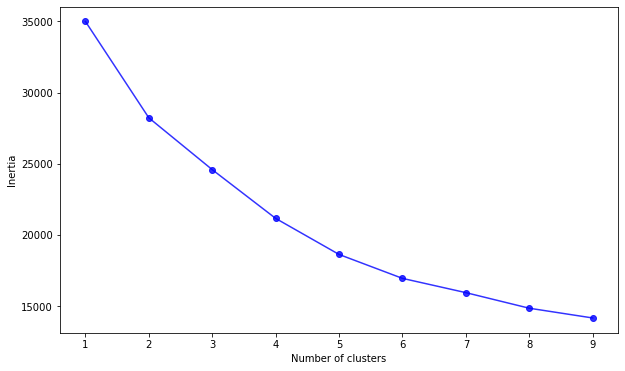

In [248]:
##inertia is calculated as the sum of squared distance for each point to it's closest centroid

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    
    model.fit(data)
    inertias.append(model.inertia_)
    
plt.figure(figsize = (10,6))    
plt.plot(ks, inertias, '-o', color = 'blue', alpha = 0.8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [249]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(data)

KMeans(n_clusters=2)

In [250]:
df_cluster_labels = pd.DataFrame(kmeans.labels_, index = df2.index, columns = ['cluster_label']).reset_index()

##### a couple of additional metrics to evaluate cluster but it could take a while. So skip if you prefer. 

In [251]:
df2.head()

,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count
customer_id,,,,,,,
1,1.00,1,0,1,1,1,1
2,1.00,1,1,1,1,1,1
3,0.75,0,0,1,5,4,4
4,1.00,1,0,0,1,3,3
5,0.00,1,0,0,2,1,1


In [252]:
df_cluster_labels.head()

,customer_id,cluster_label
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0


In [253]:
df_cluster = df2.merge(df_cluster_labels, how = 'left', left_on = 'customer_id', right_on = 'customer_id')

df_cluster.head(5)

,customer_id,ad_ind,prime,ma_ind,edu_ind,income_level,product_count,brand_count,cluster_label
0,1,1.00,1,0,1,1,1,1,0
1,2,1.00,1,1,1,1,1,1,0
2,3,0.75,0,0,1,5,4,4,1
3,4,1.00,1,0,0,1,3,3,1
4,5,0.00,1,0,0,2,1,1,0


In [254]:
df_cluster.groupby('cluster_label').describe()

customer_id                                                 \
                    count         mean          std  min     25%     50%   
cluster_label                                                              
0                  2719.0  2509.674145  1447.258474  1.0  1248.0  2518.0   
1                  2281.0  2489.564226  1439.291743  3.0  1261.0  2486.0   

                               ad_ind                                          \
                  75%     max   count      mean       std  min  25%       50%   
cluster_label                                                                   
0              3772.0  5000.0  2719.0  0.664276  0.460259  0.0  0.0  1.000000   
1              3722.0  4998.0  2281.0  0.664910  0.315390  0.0  0.5  0.666667   

                          prime                                               \
               75%  max   count      mean       std  min  25%  50%  75%  max   
cluster_label                                                                  
0              1.0  1.0  2719.0  0.848841  0.358269  0.0  1.0  1.0  1.0  1.0   
1              1.0  1.0  2281.0  0.856203  0.350960  0.0  1.0  1.0  1.0  1.0   

               ma_ind                                              edu_ind  \
                count      mean       std  min  25%  50%  75%  max   count   
cluster_label                                                                
0              2719.0  0.607944  0.488299  0.0  0.0  1.0  1.0  1.0  2719.0   
1              2281.0  0.597983  0.490413  0.0  0.0  1.0  1.0  1.0  2281.0   

                                                           income_level  \
                   mean       std  min  25%  50%  75%  max        count   
cluster_label                                                             
0              0.606473  0.488622  0.0  0.0  1.0  1.0  1.0       2719.0   
1              0.598422  0.490325  0.0  0.0  1.0  1.0  1.0       2281.0   

                                                           product_count  \
                   mean       std  min  25%  50%  75%  max         count   
cluster_label                                                              
0              3.101876  1.634657  0.0  2.0  3.0  5.0  5.0        2719.0   
1              3.117054  1.660922  0.0  2.0  3.0  5.0  5.0        2281.0   

                                                           brand_count  \
                   mean       std  min  25%  50%  75%  max       count   
cluster_label                                                            
0              1.088636  0.284269  1.0  1.0  1.0  1.0  2.0      2719.0   
1              2.493205  0.739886  2.0  2.0  2.0  3.0  7.0      2281.0   

                                                           
                   mean      std  min  25%  50%  75%  max  
cluster_label                                              
0              1.000000  0.00000  1.0  1.0  1.0  1.0  1.0  
1              2.320473  0.59336  1.0  2.0  2.0  3.0  5.0

## cross sell 

In [255]:
df.columns

Index(['sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime',
       'ad_ind', 'ma_ind', 'edu_ind', 'income_level', 'product_count',
       'brand_count'],
      dtype='object')

In [256]:
df['rev'] = df['price'] * df['qty']

In [257]:
df['date'] = pd.to_datetime(df['sale_date'])
df['month'] =  df['date'].dt.month
df['dayinmonth'] = df['date'].dt.day
df['year'] =df['date'].dt.year

In [258]:
dfc=df.groupby('customer_id').agg({'dayinmonth':'mean','month':'mean','price':'mean','qty':'mean','rev':'sum','product_count':'mean','brand_count':'mean' })
dfc.head()

,dayinmonth,month,price,qty,rev,product_count,brand_count
customer_id,,,,,,,
1,2.000000,3.000000,60.780000,3.0,182.34,1,1
2,23.000000,2.000000,73.990000,1.0,73.99,1,1
3,14.000000,5.500000,22.417500,1.0,89.67,4,4
4,17.666667,8.666667,28.166667,1.0,84.50,3,3
5,13.000000,3.000000,18.990000,1.0,18.99,1,1


In [259]:
dffc = pd.merge(df, dfc, how="left", on=["customer_id"],suffixes=(None, '_c'))
dffc.head()

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count,rev,date,month,dayinmonth,year,dayinmonth_c,month_c,price_c,qty_c,rev_c,product_count_c,brand_count_c
0,1,2022-01-01,Sponsored Products,224143037,Seattle Gourmet,Seattle Gourmet Adult 7+ Small Bites Chicken M...,16.14,2,1223,M,Shreveport,LA,71130,32.6076,-93.7526,Single,College graduate,"$60,000 - $79,999",55-64,1,1,0,1,3,1,1,32.28,2022-01-01,1,1,2022,1.000000,1.0,16.140000,2.0,32.28,1,1
1,2,2022-01-01,Don't recall seeing an ad,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,3,2946,M,Fresno,CA,93794,36.7464,-119.6397,Single,High school graduate,"$60,000 - $79,999",35-44,1,0,0,0,3,1,1,65.49,2022-01-01,1,1,2022,1.000000,1.0,21.830000,3.0,65.49,1,1
2,3,2022-01-01,Don't recall seeing an ad,950844039,Doggo,"Doggo Kibble Dry Dog Food, 20 lb, with Plant B...",57.99,3,4448,M,Danbury,CT,6816,41.3089,-73.3637,Single,College graduate,"Less than $20,000",25-34,1,0,0,1,0,1,1,173.97,2022-01-01,1,1,2022,1.000000,1.0,57.990000,3.0,173.97,1,1
3,4,2022-01-01,Sponsored Products,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",63.98,2,4510,F,San Antonio,TX,78215,29.4413,-98.4793,Married,College graduate,"$20,000 - $39,999",25-34,1,1,1,1,1,1,1,127.96,2022-01-01,1,1,2022,1.000000,1.0,63.980000,2.0,127.96,1,1
4,5,2022-01-01,Don't recall seeing an ad,151595003,Alpha,"Alpha Natural Sensitive Systems, Skin & Coat S...",48.99,1,370,F,Boise,ID,83711,43.4599,-116.2440,Married,Some college or trade school,"$80,000 - $99,999",55-64,0,0,1,0,4,2,2,48.99,2022-01-01,1,1,2022,15.333333,2.0,38.506667,1.0,115.52,2,2


In [260]:
dffc.groupby('product_brand')[['product_count_c','brand_count_c']].describe()

product_count_c                                            \
                          count      mean       std  min   25%  50%   75%   
product_brand                                                               
Alpha                    2832.0  2.182910  1.029287  1.0  1.00  2.0  3.00   
Arf                       934.0  2.192719  1.040092  1.0  1.00  2.0  3.00   
Astro                      94.0  2.074468  0.964302  1.0  1.00  2.0  2.75   
Beam                      252.0  2.250000  1.024112  1.0  1.75  2.0  3.00   
Beethoven                 108.0  2.222222  1.035206  1.0  1.00  2.0  3.00   
Bezt                     1601.0  2.171143  1.008435  1.0  1.00  2.0  3.00   
Bones                      40.0  2.400000  1.057331  1.0  2.00  2.0  3.00   
Doggo                      70.0  2.085714  0.959209  1.0  1.00  2.0  3.00   
Garland Farms             340.0  2.158824  1.023937  1.0  1.00  2.0  3.00   
Hanover                    74.0  2.054054  0.949288  1.0  1.00  2.0  3.00   
Health One                746.0  2.199732  1.081411  1.0  1.00  2.0  3.00   
Hearth                     45.0  2.200000  0.894427  1.0  2.00  2.0  3.00   
K99                        62.0  2.258065  0.990702  1.0  2.00  2.0  3.00   
Kastle                     36.0  2.166667  1.108409  1.0  1.00  2.0  3.00   
King                      220.0  2.268182  1.058079  1.0  2.00  2.0  3.00   
Oh My Dog!                 40.0  2.400000  1.215287  1.0  1.00  2.0  3.00   
Pawsome                   196.0  2.280612  1.026736  1.0  2.00  2.0  3.00   
Perro                      76.0  2.013158  0.972878  1.0  1.00  2.0  3.00   
Playtime                   45.0  2.355556  1.351019  1.0  1.00  2.0  3.00   
Rivera                     62.0  2.080645  0.963232  1.0  1.00  2.0  3.00   
Romero                     91.0  2.131868  1.087390  1.0  1.00  2.0  3.00   
Ruby                      146.0  2.246575  0.993508  1.0  1.25  2.0  3.00   
Seattle Gourmet           339.0  2.209440  1.159129  1.0  1.00  2.0  3.00   
Spot's Choice             510.0  2.176471  1.006968  1.0  1.00  2.0  3.00   
Top                       256.0  2.152344  1.019532  1.0  1.00  2.0  3.00   

                     brand_count_c                                           \
                 max         count      mean       std  min   25%  50%  75%   
product_brand                                                                 
Alpha            7.0        2832.0  1.801907  0.835428  1.0  1.00  2.0  2.0   
Arf              7.0         934.0  2.012848  0.894095  1.0  1.00  2.0  3.0   
Astro            5.0          94.0  2.000000  0.829561  1.0  1.00  2.0  2.0   
Beam             7.0         252.0  2.115079  0.900780  1.0  1.00  2.0  3.0   
Beethoven        5.0         108.0  2.138889  0.941845  1.0  1.00  2.0  3.0   
Bezt             6.0        1601.0  1.950031  0.863859  1.0  1.00  2.0  2.0   
Bones            6.0          40.0  2.300000  0.939176  1.0  2.00  2.0  3.0   
Doggo            5.0          70.0  2.042857  0.875359  1.0  1.00  2.0  3.0   
Garland Farms    7.0         340.0  2.050000  0.889383  1.0  1.00  2.0  3.0   
Hanover          5.0          74.0  1.972973  0.875433  1.0  1.00  2.0  2.0   
Health One       7.0         746.0  2.041555  0.916451  1.0  1.00  2.0  3.0   
Hearth           4.0          45.0  2.177778  0.886487  1.0  2.00  2.0  3.0   
K99              5.0          62.0  2.161290  0.853028  1.0  2.00  2.0  3.0   
Kastle           4.0          36.0  2.027778  0.970600  1.0  1.00  2.0  3.0   
King             7.0         220.0  2.177273  0.946241  1.0  2.00  2.0  3.0   
Oh My Dog!       6.0          40.0  2.325000  1.118321  1.0  1.00  2.0  3.0   
Pawsome          5.0         196.0  2.173469  0.928473  1.0  2.00  2.0  3.0   
Perro            4.0          76.0  1.960526  0.930101  1.0  1.00  2.0  2.0   
Playtime         6.0          45.0  2.244444  1.208973  1.0  1.00  2.0  3.0   
Rivera           5.0          62.0  1.967742  0.829136  1.0  1.00  2.0  2.0   
Romero           7.0          91.0  2.0329

In [261]:
dffc.groupby('product_brand')[['dayinmonth_c','month_c']].describe()

dayinmonth_c                                            \
                       count       mean       std       min        25%   
product_brand                                                            
Alpha                 2832.0  15.600077  6.562892  1.000000  11.000000   
Arf                    934.0  15.670761  6.518444  1.000000  11.000000   
Astro                   94.0  15.247518  6.807294  1.000000  11.000000   
Beam                   252.0  16.275028  6.425750  1.000000  11.500000   
Beethoven              108.0  15.426389  6.244474  2.500000  11.175000   
Bezt                  1601.0  15.683144  6.625448  1.000000  11.200000   
Bones                   40.0  14.655298  6.058619  1.000000  10.562500   
Doggo                   70.0  17.757857  7.228863  1.000000  13.750000   
Garland Farms          340.0  15.427689  6.719592  1.000000  11.000000   
Hanover                 74.0  14.365766  7.130428  1.000000   9.125000   
Health One             746.0  15.638692  6.547209  1.000000  11.000000   
Hearth                  45.0  16.090741  4.874039  5.333333  12.666667   
K99                     62.0  15.671505  6.846149  2.000000  10.687500   
Kastle                  36.0  15.460648  7.241593  2.000000  10.375000   
King                   220.0  15.546277  6.720941  1.000000  11.000000   
Oh My Dog!              40.0  18.412500  6.155191  3.000000  14.125000   
Pawsome                196.0  14.901190  6.033915  2.000000  10.625000   
Perro                   76.0  15.879386  6.603666  1.000000  11.187500   
Playtime                45.0  15.170370  6.091270  4.000000  10.000000   
Rivera                  62.0  16.311022  6.179848  3.000000  11.750000   
Romero                  91.0  17.043302  7.023246  2.000000  11.833333   
Ruby                   146.0  15.551142  6.418629  1.000000  12.083333   
Seattle Gourmet        339.0  15.184317  6.395501  1.000000  11.000000   
Spot's Choice          510.0  15.421797  6.860583  1.000000  10.270833   
Top                    256.0  16.262277  6.756275  1.000000  12.000000   

                                                 month_c                      \
                       50%        75%        max   count      mean       std   
product_brand                                                                  
Alpha            15.500000  20.000000  31.000000  2832.0  6.717917  2.545056   
Arf              15.500000  20.000000  31.000000   934.0  6.778314  2.579714   
Astro            16.000000  20.250000  30.000000    94.0  6.608511  2.947031   
Beam             16.000000  20.714286  31.000000   252.0  6.757984  2.446511   
Beethoven        15.000000  20.000000  30.000000   108.0  7.158488  2.428104   
Bezt             16.000000  20.000000  31.000000  1601.0  6.757052  2.615293   
Bones            14.041667  19.375000  27.000000    40.0  5.986071  2.412326   
Doggo            17.833333  23.000000  30.000000    70.0  6.665952  2.534202   
Garland Farms    15.000000  20.000000  31.000000   340.0  6.697297  2.564176   
Hanover          14.333333  19.937500  31.000000    74.0  7.192793  2.848548   
Health One       16.000000  20.000000  31.000000   746.0  6.754012  2.488114   
Hearth           16.000000  18.000000  26.500000    45.0  7.085185  2.239276   
K99              14.733333  21.875000  30.000000    62.0  6.721237  2.753336   
Kastle           15.250000  19.625000  29.000000    36.0  6.414352  2.632104   
King             16.000000  20.500000  30.000000   220.0  6.782338  2.539497   
Oh My Dog!       18.333333  22.250000  29.000000    40.0  6.833333  2.788292   
Pawsome          14.333333  19.000000  28.666667   196.0  6.460459  2.546768   
Perro            15.750000  21.750000  30.000000    76.0  6.393640  2.610293   
Playtime         15.000000  19.000000  31.000000    45.0  6.084074  2.430278   
Rivera           16.250000  19.916667  30.000000    62.0  6.569624  2.547445   
Romero           17.000000  22.000000  31.000000    91.0  7.073391  2.738746   
Ruby             15.583

need sort sequentially first 

In [262]:
df.sort_values(['customer_id','sale_date'], ascending=[True,True],inplace=True)
df.head(20)

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count,rev,date,month,dayinmonth,year
1508,1509,2022-03-02,Video ad,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",60.78,3,1,M,Syracuse,NY,13251,43.0214,-76.1977,Single,College graduate,"$20,000 - $39,999",35-44,1,1,0,1,1,1,1,182.34,2022-03-02,3,2,2022
1355,1356,2022-02-23,Sponsored Products,794803062,K99,K99 Super Premium Dog Food Ð Professional Dry ...,73.99,1,2,M,Vienna,VA,22184,38.8318,-77.2888,Married,College graduate,"$20,000 - $39,999",55-64,1,1,1,1,1,1,1,73.99,2022-02-23,2,23,2022
1483,1484,2022-03-01,Don't recall seeing an ad,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,39.06,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,0,0,1,5,4,4,39.06,2022-03-01,3,1,2022
2672,2673,2022-04-23,Sponsored Products,287844069,Health One,Health One Ultra High Protein Natural Dry Dog ...,18.99,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,18.99,2022-04-23,4,23,2022
3776,3777,2022-06-08,Display/banner ad,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,12.13,2022-06-08,6,8,2022
6470,6471,2022-09-24,Display/banner ad,850781043,Spot's Choice,Spot's Choice Dry Dog Food,19.49,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,19.49,2022-09-24,9,24,2022
1422,1423,2022-02-26,Sponsored Brands,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,21.83,2022-02-26,2,26,2022
8592,8593,2022-12-11,Sponsored Brands,718796049,Top,"Top Grain-Free Salmon, Sweet Potato & Pumpkin ...",43.68,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,43.68,2022-12-11,12,11,2022
8741,8742,2022-12-16,Display/banner ad,987968089,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",18.99,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,18.99,2022-12-16,12,16,2022
1781,1782,2022-03-13,Don't recall seeing an ad,987968089,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",18.99,1,5,M,Kansas City,MO,64153,39.2627,-94.6970,Single,Some college or trade school,"$40,000 - $59,999",45-54,1,0,0,0,2,1,1,18.99,2022-03-13,3,13,2022


In [263]:
df['brand_seq'] = df.groupby(['customer_id'])['product_brand'].transform(lambda x: '-'.join(x))

In [264]:
df['brand_seq'].value_counts(ascending=False).head(20)

Alpha                   719
Bezt                    429
Alpha-Alpha             332
Arf                     240
Health One              196
Alpha-Bezt              160
Bezt-Alpha              142
Spot's Choice           135
Alpha-Alpha-Alpha       111
Alpha-Arf               110
Seattle Gourmet          98
Garland Farms            92
Arf-Alpha                92
Bezt-Bezt                88
Health One-Alpha         78
Top                      70
Beam                     61
Arf-Bezt                 58
Alpha-Health One         58
Alpha-Spot's Choice      56
Name: brand_seq, dtype: int64

In [265]:
df['product_seq'] = df.groupby(['customer_id'])['product_name'].transform(lambda x: ';'.join(x))

In [266]:
df['product_seq'].value_counts(ascending=False).head(20)

Alpha Natural Healthy Weight Formula Adult Dry Dog Food & Wet Dog Food                       120
Alpha Natural Adult Chicken & Rice Dry Dog Food                                               88
Bezt Natural Adult Small Breed Dry Dog Food                                                   86
Alpha Natural Adult Lamb & Rice Dry Dog Food                                                  83
Alpha Sensitive Skin & Stomach, High Protein Dry Dog Food                                     82
Alpha Natural Sensitive Systems, Skin & Coat Salmon Adult Dry Dog Food                        77
Alpha Shredded Blend High Protein, Adult Dry Dog Food Chicken & Rice (Packaging May Vary)     67
Bezt Natural Adult Healthy Weight Chicken and Brown Rice Dry Dog Food                         64
Spot's Choice Chopped Ground Dinner Adult Wet Dog Food, 3.5 oz. Pouches                       58
Health One NATURAL CHOICE Natural Adult Dry Dog Food, Chicken                                 57
Health One Natural Spot's Choi

## interpurchase timing

In [267]:
df.columns

Index(['sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime',
       'ad_ind', 'ma_ind', 'edu_ind', 'income_level', 'product_count',
       'brand_count', 'rev', 'date', 'month', 'dayinmonth', 'year',
       'brand_seq', 'product_seq'],
      dtype='object')

In [268]:
df['diff_pur'] = df.groupby('customer_id')['date'].diff().dt.days

In [269]:
df.head(20)

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count,rev,date,month,dayinmonth,year,brand_seq,product_seq,diff_pur
1508,1509,2022-03-02,Video ad,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",60.78,3,1,M,Syracuse,NY,13251,43.0214,-76.1977,Single,College graduate,"$20,000 - $39,999",35-44,1,1,0,1,1,1,1,182.34,2022-03-02,3,2,2022,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",NaN
1355,1356,2022-02-23,Sponsored Products,794803062,K99,K99 Super Premium Dog Food Ð Professional Dry ...,73.99,1,2,M,Vienna,VA,22184,38.8318,-77.2888,Married,College graduate,"$20,000 - $39,999",55-64,1,1,1,1,1,1,1,73.99,2022-02-23,2,23,2022,K99,K99 Super Premium Dog Food Ð Professional Dry ...,NaN
1483,1484,2022-03-01,Don't recall seeing an ad,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,39.06,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,0,0,1,5,4,4,39.06,2022-03-01,3,1,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,NaN
2672,2673,2022-04-23,Sponsored Products,287844069,Health One,Health One Ultra High Protein Natural Dry Dog ...,18.99,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,18.99,2022-04-23,4,23,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,53.0
3776,3777,2022-06-08,Display/banner ad,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,12.13,2022-06-08,6,8,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,46.0
6470,6471,2022-09-24,Display/banner ad,850781043,Spot's Choice,Spot's Choice Dry Dog Food,19.49,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,19.49,2022-09-24,9,24,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,108.0
1422,1423,2022-02-26,Sponsored Brands,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,21.83,2022-02-26,2,26,2022,Garland Farms-Top-Oh My Dog!,Garland Farms Healthy Grains Dry Dog Food with...,NaN
8592,8593,2022-12-11,Sponsored Brands,718796049,Top,"Top Grain-Free Salmon, Sweet Potato & Pumpkin ...",43.68,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,43.68,2022-12-11,12,11,2022,Garland Farms-Top-Oh My Dog!,Garland Farms Healthy Grains Dry Dog Food with...,288.0
8741,8742,2022-12-16,Display/banner ad,987968089,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",18.99,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,18.99,2022-12-16,12,16,2022,Garland Farms-Top-Oh My Dog!,Garland Farms Healthy Grains Dry Dog Food with...,5.0
1781,1782,2022-03-13,Don't recall seeing an ad,987968089,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",18.99,1,5,M,Kansas City,MO,64153,39.2627,-94.6970,Single,Some college or trade school,"$40,000 - $59,999",45-54,1,0,0,0,2,1,1,18.99,2022-03-13,3,13,2022,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",NaN


In [270]:
df.groupby('product_brand')['diff_pur'].describe()

,count,mean,std,min,25%,50%,75%,max
product_brand,,,,,,,,
Alpha,1274.0,99.575353,80.159245,0.0,35.00,77.5,147.00,362.0
Arf,429.0,98.778555,80.127876,0.0,35.00,79.0,145.00,346.0
Astro,43.0,99.395349,77.215573,6.0,38.00,75.0,162.50,287.0
Beam,121.0,95.033058,76.963079,1.0,26.00,85.0,139.00,326.0
Beethoven,54.0,111.870370,75.576288,1.0,56.00,90.0,185.75,246.0
Bezt,759.0,98.722003,80.253674,0.0,34.00,74.0,146.00,356.0
Bones,21.0,81.952381,83.669275,2.0,14.00,46.0,139.00,309.0
Doggo,29.0,132.586207,94.696703,6.0,50.00,124.0,154.00,323.0
Garland Farms,154.0,94.811688,78.369976,0.0,30.25,79.0,136.00,327.0


## naming 

In [271]:
df.columns

Index(['sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime',
       'ad_ind', 'ma_ind', 'edu_ind', 'income_level', 'product_count',
       'brand_count', 'rev', 'date', 'month', 'dayinmonth', 'year',
       'brand_seq', 'product_seq', 'diff_pur'],
      dtype='object')

In [272]:
df.head()

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count,rev,date,month,dayinmonth,year,brand_seq,product_seq,diff_pur
1508,1509,2022-03-02,Video ad,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",60.78,3,1,M,Syracuse,NY,13251,43.0214,-76.1977,Single,College graduate,"$20,000 - $39,999",35-44,1,1,0,1,1,1,1,182.34,2022-03-02,3,2,2022,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",NaN
1355,1356,2022-02-23,Sponsored Products,794803062,K99,K99 Super Premium Dog Food Ð Professional Dry ...,73.99,1,2,M,Vienna,VA,22184,38.8318,-77.2888,Married,College graduate,"$20,000 - $39,999",55-64,1,1,1,1,1,1,1,73.99,2022-02-23,2,23,2022,K99,K99 Super Premium Dog Food Ð Professional Dry ...,NaN
1483,1484,2022-03-01,Don't recall seeing an ad,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,39.06,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,0,0,1,5,4,4,39.06,2022-03-01,3,1,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,NaN
2672,2673,2022-04-23,Sponsored Products,287844069,Health One,Health One Ultra High Protein Natural Dry Dog ...,18.99,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,18.99,2022-04-23,4,23,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,53.0
3776,3777,2022-06-08,Display/banner ad,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,12.13,2022-06-08,6,8,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,46.0


In [273]:
## regular expressions to extract digits, note this is not perfect but can roughly categorize into big, medium or small 
df['size']= df['product_name'].str.extract('(\d+)')

In [274]:
df.dtypes

sale_id                   int64
sale_date                object
ad_exp                   object
product_id                int64
product_brand            object
product_name             object
price                   float64
qty                       int64
customer_id               int64
gender                   object
city                     object
st                       object
zip                       int64
lat                     float64
lng                     float64
marital                  object
education                object
income                   object
age                      object
prime                     int64
ad_ind                    int64
ma_ind                    int64
edu_ind                   int64
income_level              int64
product_count             int64
brand_count               int64
rev                     float64
date             datetime64[ns]
month                     int64
dayinmonth                int64
year                      int64
brand_se

In [275]:
df['size'].value_counts()

3     401
12    393
7     145
4     135
2     123
35    105
17     97
1      89
13     74
20     70
99     62
28     58
6      52
15     49
24     45
Name: size, dtype: int64

In [276]:
df['size_2'] = np.where(df['size']=='35','3.5',df['size'])

In [277]:
df['size_2'].value_counts()

3      401
12     393
7      145
4      135
2      123
3.5    105
17      97
1       89
13      74
20      70
99      62
28      58
6       52
15      49
24      45
Name: size_2, dtype: int64

Based on size information, you can define a function similar to income and categorize products. Feel free to give it a try 

In [278]:
## check partial strings

df['natural'] = df['product_name'].str.contains('natural').any()

In [279]:
df[df['natural']==True][['natural', 'product_name']].head(35)

,natural,product_name


What went wrong? String is case sensitive, so you need to do all lower or upper case to search for. See below the right coding. 

In [280]:
searchfor = ['natural', 'organic', 'sensitive']
df['natural2'] = df['product_name'].apply(str.lower).apply(lambda x: 1 if any(i in x for i in searchfor) else 0)

In [281]:
df[['natural2', 'product_name']].head(5)

,natural2,product_name
1508,0,"Alpha Shredded Blend High Protein, Adult Dry D..."
1355,0,K99 Super Premium Dog Food Ð Professional Dry ...
1483,1,Alpha Natural Adult Chicken & Rice Dry Dog Food
2672,1,Health One Ultra High Protein Natural Dry Dog ...
3776,0,Arf Soft & Tender American Jerky Dog Treats


In [282]:
df.to_csv('test.csv')

### brand and industry analysis 

In [283]:
df.columns

Index(['sale_id', 'sale_date', 'ad_exp', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime',
       'ad_ind', 'ma_ind', 'edu_ind', 'income_level', 'product_count',
       'brand_count', 'rev', 'date', 'month', 'dayinmonth', 'year',
       'brand_seq', 'product_seq', 'diff_pur', 'size', 'size_2', 'natural',
       'natural2'],
      dtype='object')

#####  by month 

In [284]:
df.groupby(['month'])['sale_id'].nunique()

month
1     854
2     619
3     731
4     674
5     732
6     676
7     772
8     753
9     836
10    824
11    845
12    899
Name: sale_id, dtype: int64

In [285]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [286]:
df.groupby(['product_brand','month'])['sale_id'].nunique()

product_brand    month
Alpha            1        272
                 2        188
                 3        240
                 4        218
                 5        199
                 6        213
                 7        231
                 8        243
                 9        259
                 10       239
                 11       252
                 12       278
Arf              1         91
                 2         57
                 3         66
                 4         61
                 5         80
                 6         66
                 7         82
                 8         87
                 9         90
                 10        85
                 11        76
                 12        93
Astro            1         13
                 2          3
                 3          9
                 4          5
                 5          6
                 6          5
                 7          7
                 8          9
                 

##### new to brand 

In [287]:
df.sort_values(['customer_id','sale_date'], ascending=[True,True],inplace=True)
df.head(20)

,sale_id,sale_date,ad_exp,product_id,product_brand,product_name,price,qty,customer_id,gender,city,st,zip,lat,lng,marital,education,income,age,prime,ad_ind,ma_ind,edu_ind,income_level,product_count,brand_count,rev,date,month,dayinmonth,year,brand_seq,product_seq,diff_pur,size,size_2,natural,natural2
1508,1509,2022-03-02,Video ad,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",60.78,3,1,M,Syracuse,NY,13251,43.0214,-76.1977,Single,College graduate,"$20,000 - $39,999",35-44,1,1,0,1,1,1,1,182.34,2022-03-02,3,2,2022,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",NaN,NaN,NaN,False,0
1355,1356,2022-02-23,Sponsored Products,794803062,K99,K99 Super Premium Dog Food Ð Professional Dry ...,73.99,1,2,M,Vienna,VA,22184,38.8318,-77.2888,Married,College graduate,"$20,000 - $39,999",55-64,1,1,1,1,1,1,1,73.99,2022-02-23,2,23,2022,K99,K99 Super Premium Dog Food Ð Professional Dry ...,NaN,99,99,False,0
1483,1484,2022-03-01,Don't recall seeing an ad,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,39.06,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,0,0,1,5,4,4,39.06,2022-03-01,3,1,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,NaN,NaN,NaN,False,1
2672,2673,2022-04-23,Sponsored Products,287844069,Health One,Health One Ultra High Protein Natural Dry Dog ...,18.99,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,18.99,2022-04-23,4,23,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,53.0,NaN,NaN,False,1
3776,3777,2022-06-08,Display/banner ad,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,12.13,2022-06-08,6,8,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,46.0,NaN,NaN,False,0
6470,6471,2022-09-24,Display/banner ad,850781043,Spot's Choice,Spot's Choice Dry Dog Food,19.49,1,3,M,Valdosta,GA,31605,30.9460,-83.2474,Single,Post graduate,"$100,000 or more",45-54,0,1,0,1,5,4,4,19.49,2022-09-24,9,24,2022,Alpha-Health One-Arf-Spot's Choice,Alpha Natural Adult Chicken & Rice Dry Dog Foo...,108.0,NaN,NaN,False,0
1422,1423,2022-02-26,Sponsored Brands,834182030,Garland Farms,Garland Farms Healthy Grains Dry Dog Food with...,21.83,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,21.83,2022-02-26,2,26,2022,Garland Farms-Top-Oh My Dog!,Garland Farms Healthy Grains Dry Dog Food with...,NaN,NaN,NaN,False,0
8592,8593,2022-12-11,Sponsored Brands,718796049,Top,"Top Grain-Free Salmon, Sweet Potato & Pumpkin ...",43.68,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,43.68,2022-12-11,12,11,2022,Garland Farms-Top-Oh My Dog!,Garland Farms Healthy Grains Dry Dog Food with...,288.0,NaN,NaN,False,0
8741,8742,2022-12-16,Display/banner ad,987968089,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",18.99,1,4,M,Birmingham,AL,35290,33.5446,-86.9292,Single,Some college or trade school,"$20,000 - $39,999",55-64,1,1,0,0,1,3,3,18.99,2022-12-16,12,16,2022,Garland Farms-Top-Oh My Dog!,Garland Farms Healthy Grains Dry Dog Food with...,5.0,NaN,NaN,False,1
1781,1782,2022-03-13,Don't recall seeing an ad,987968089,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",18.99,1,5,M,Kansas City,MO,64153,39.2627,-94.6970,Single,Some college or trade school,"$40,000 - $59,999",45-54,1,0,0,0,2,1,1,18.99,2022-03-13,3,13,2022,Oh My Dog!,"Oh My Dog! Natural Dry Dog Food, Raw Coated Wh...",NaN,NaN,NaN,False,1


In [23]:
df['order_seq'] = df.groupby(['customer_id','product_brand']).cumcount()+1

In [289]:
df_test= df[['customer_id', 'sale_date','product_brand','order_seq']].head(30)

In [290]:
df_test.to_csv('try.csv')

In [24]:
df['ntb'] = np.where(df['order_seq']==1, 1, 0)

In [292]:
df.groupby('month')['ntb'].describe().unstack()[['count','mean']]

       month
count  1        854.000000
       2        619.000000
       3        731.000000
       4        674.000000
       5        732.000000
       6        676.000000
       7        772.000000
       8        753.000000
       9        836.000000
       10       824.000000
       11       845.000000
       12       899.000000
mean   1          0.992974
       2          0.957997
       3          0.932969
       4          0.900593
       5          0.907104
       6          0.871302
       7          0.863990
       8          0.836653
       9          0.819378
       10         0.797330
       11         0.804734
       12         0.789766
dtype: float64

In [293]:
df_test= df.groupby('month')['ntb'].describe().unstack()[['count','mean']] 
df_test.to_csv('test2.csv')

In [294]:
## generate excel directly without generating dataframe to save memory space 
df.groupby('month')['ntb'].describe().unstack()[['count','mean']].to_csv('test3.csv')


##### upsell next time around 

In [295]:
df.sort_values(['customer_id','product_brand', 'order_seq'], ascending=[True,True, True],inplace=True)

In [335]:
df['price_diff_wb'] = df.groupby(['customer_id','product_brand'])['price'].diff()

In [297]:
df[(df['order_seq']>=2) & (df['product_brand'] == 'Alpha') & (df['price']> 50)][['customer_id','product_brand', 'order_seq', 'price', 'price_diff_wb']].head(5)

,customer_id,product_brand,order_seq,price,price_diff_wb
4701,20,Alpha,2,53.66,11.50
5174,37,Alpha,3,63.98,37.49
3226,73,Alpha,2,60.78,11.79
2295,77,Alpha,2,53.66,12.54
1308,113,Alpha,2,79.31,38.19


In [298]:
df.groupby('product_brand')['price_diff_wb'].describe().unstack()[['count','mean']].to_csv('test4.csv')

##### AD exposure 

In [336]:
df.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'ad_exp', 'product_id',
       'product_brand', 'product_name', 'price', 'qty', 'customer_id',
       'gender', 'city', 'st', 'zip', 'lat', 'lng', 'marital', 'education',
       'income', 'age', 'prime', 'ad_ind', 'ma_ind', 'edu_ind', 'income_level',
       'product_count', 'brand_count', 'rev', 'date', 'month', 'dayinmonth',
       'year', 'brand_seq', 'product_seq', 'diff_pur', 'size', 'size_2',
       'natural', 'natural2', 'order_seq', 'ntb', 'price_diff_wb'],
      dtype='object')

In [300]:
df.groupby('ad_exp')[['rev','ntb','price_diff_wb']].describe().unstack().to_csv('test4.csv')

In [303]:
## or save as dataframe first and then export output 
df.groupby('ad_exp')[['rev','ntb','price_diff_wb']].describe().unstack()


                      ad_exp                   
rev            count  Display/banner ad            1297.000000
                      Don't recall seeing an ad    3096.000000
                      Some other type of ad          31.000000
                      Sponsored Brands             2520.000000
                      Sponsored Products           2017.000000
                      Video ad                      254.000000
               mean   Display/banner ad              43.657903
                      Don't recall seeing an ad      41.784900
                      Some other type of ad          52.256129
                      Sponsored Brands               41.834266
                      Sponsored Products             41.943996
                      Video ad                       43.226063
               std    Display/banner ad              26.499778
                      Don't recall seeing an ad      25.069474
                      Some other type of ad          30.883376
       

In [304]:
pip install statsmodels


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [305]:
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot
import warnings
from IPython.display import display, Math, Latex, Markdown

In [306]:
## ANOVA

In [321]:
model = ols("rev ~ C(ad_exp)", df).fit()
res = anova_lm(model, typ=1)

In [322]:
print(res)

               df        sum_sq      mean_sq         F    PR(>F)
C(ad_exp)     5.0  7.154463e+03  1430.892696  2.264682  0.045422
Residual   9209.0  5.818516e+06   631.829339       NaN       NaN


In [323]:
df.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'ad_exp', 'product_id',
       'product_brand', 'product_name', 'price', 'qty', 'customer_id',
       'gender', 'city', 'st', 'zip', 'lat', 'lng', 'marital', 'education',
       'income', 'age', 'prime', 'ad_ind', 'ma_ind', 'edu_ind', 'income_level',
       'product_count', 'brand_count', 'rev', 'date', 'month', 'dayinmonth',
       'year', 'brand_seq', 'product_seq', 'diff_pur', 'size', 'size_2',
       'natural', 'natural2'],
      dtype='object')

In [324]:
## OLS 

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
df=pd.read_csv('test.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'ad_exp', 'product_id',
       'product_brand', 'product_name', 'price', 'qty', 'customer_id',
       'gender', 'city', 'st', 'zip', 'lat', 'lng', 'marital', 'education',
       'income', 'age', 'prime', 'ad_ind', 'ma_ind', 'edu_ind', 'income_level',
       'product_count', 'brand_count', 'rev', 'date', 'month', 'dayinmonth',
       'year', 'brand_seq', 'product_seq', 'diff_pur', 'size', 'size_2',
       'natural', 'natural2'],
      dtype='object')

In [4]:
df['ad_exp'].value_counts()

Don't recall seeing an ad    3096
Sponsored Brands             2520
Sponsored Products           2017
Display/banner ad            1297
Video ad                      254
Some other type of ad          31
Name: ad_exp, dtype: int64

In [10]:
df2= pd.get_dummies(df, columns=['ad_exp'])

In [11]:
df2['date']=pd.to_datetime(df2['sale_date'])

In [12]:
df2.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'customer_id', 'gender', 'city', 'st',
       'zip', 'lat', 'lng', 'marital', 'education', 'income', 'age', 'prime',
       'ad_ind', 'ma_ind', 'edu_ind', 'income_level', 'product_count',
       'brand_count', 'rev', 'date', 'month', 'dayinmonth', 'year',
       'brand_seq', 'product_seq', 'diff_pur', 'size', 'size_2', 'natural',
       'natural2', 'ad_exp_Display/banner ad',
       'ad_exp_Don't recall seeing an ad', 'ad_exp_Some other type of ad',
       'ad_exp_Sponsored Brands', 'ad_exp_Sponsored Products',
       'ad_exp_Video ad'],
      dtype='object')

In [13]:
df2.head()

,Unnamed: 0,sale_id,sale_date,product_id,product_brand,product_name,price,qty,customer_id,gender,...,size,size_2,natural,natural2,ad_exp_Display/banner ad,ad_exp_Don't recall seeing an ad,ad_exp_Some other type of ad,ad_exp_Sponsored Brands,ad_exp_Sponsored Products,ad_exp_Video ad
0,1508,1509,2022-03-02,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",60.78,3,1,M,...,NaN,NaN,False,0,0,0,0,0,0,1
1,1355,1356,2022-02-23,794803062,K99,K99 Super Premium Dog Food Ð Professional Dry ...,73.99,1,2,M,...,99.0,99.0,False,0,0,0,0,0,1,0
2,1483,1484,2022-03-01,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,39.06,1,3,M,...,NaN,NaN,False,1,0,1,0,0,0,0
3,2672,2673,2022-04-23,287844069,Health One,Health One Ultra High Protein Natural Dry Dog ...,18.99,1,3,M,...,NaN,NaN,False,1,0,0,0,0,1,0
4,3776,3777,2022-06-08,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,3,M,...,NaN,NaN,False,0,1,0,0,0,0,0


In [15]:
df2 = df2.set_index(['date','customer_id'])
df2.head()

,,Unnamed: 0,sale_id,sale_date,product_id,product_brand,product_name,price,qty,gender,city,...,size,size_2,natural,natural2,ad_exp_Display/banner ad,ad_exp_Don't recall seeing an ad,ad_exp_Some other type of ad,ad_exp_Sponsored Brands,ad_exp_Sponsored Products,ad_exp_Video ad
date,customer_id,,,,,,,,,,,,,,,,,,,,,
2022-03-02,1,1508,1509,2022-03-02,378059009,Alpha,"Alpha Shredded Blend High Protein, Adult Dry D...",60.78,3,M,Syracuse,...,NaN,NaN,False,0,0,0,0,0,0,1
2022-02-23,2,1355,1356,2022-02-23,794803062,K99,K99 Super Premium Dog Food Ð Professional Dry ...,73.99,1,M,Vienna,...,99.0,99.0,False,0,0,0,0,0,1,0
2022-03-01,3,1483,1484,2022-03-01,171309001,Alpha,Alpha Natural Adult Chicken & Rice Dry Dog Food,39.06,1,M,Valdosta,...,NaN,NaN,False,1,0,1,0,0,0,0
2022-04-23,3,2672,2673,2022-04-23,287844069,Health One,Health One Ultra High Protein Natural Dry Dog ...,18.99,1,M,Valdosta,...,NaN,NaN,False,1,0,0,0,0,1,0
2022-06-08,3,3776,3777,2022-06-08,963900014,Arf,Arf Soft & Tender American Jerky Dog Treats,12.13,1,M,Valdosta,...,NaN,NaN,False,0,1,0,0,0,0,0


In [16]:
df2.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'gender', 'city', 'st', 'zip', 'lat',
       'lng', 'marital', 'education', 'income', 'age', 'prime', 'ad_ind',
       'ma_ind', 'edu_ind', 'income_level', 'product_count', 'brand_count',
       'rev', 'month', 'dayinmonth', 'year', 'brand_seq', 'product_seq',
       'diff_pur', 'size', 'size_2', 'natural', 'natural2',
       'ad_exp_Display/banner ad', 'ad_exp_Don't recall seeing an ad',
       'ad_exp_Some other type of ad', 'ad_exp_Sponsored Brands',
       'ad_exp_Sponsored Products', 'ad_exp_Video ad'],
      dtype='object')

In [18]:
## include all exogenous variables you plan to test 
exog_vars = ['ma_ind', 'ad_exp_Display/banner ad', 'ad_exp_Some other type of ad',
       'ad_exp_Sponsored Brands', 'ad_exp_Sponsored Products',
       'ad_exp_Video ad']
exog = sm.add_constant(df2[exog_vars])

In [19]:
from linearmodels import PooledOLS


mod = PooledOLS(df2.rev, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [20]:
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    rev   R-squared:                        0.0013
Estimator:                  PooledOLS   R-squared (Between):              0.0014
No. Observations:                9215   R-squared (Within):               0.0013
Date:                Fri, Mar 03 2023   R-squared (Overall):              0.0013
Time:                        20:09:03   Log-likelihood                -4.278e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.9828
Entities:                         365   P-value                           0.0644
Avg Obs:                       25.247   Distribution:                  F(6,9208)
Min Obs:                       12.000                                           
Max Obs:                       43.000   F-statistic (robust):             1.4695
                            

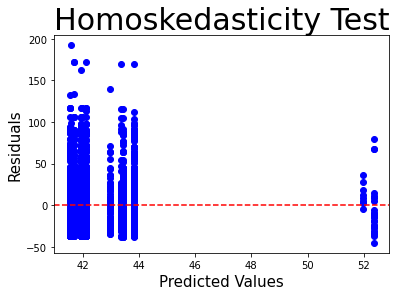

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [22]:
mod2 = sm.OLS(df2.rev, exog)
OLS_res =mod2.fit()
print(OLS_res.summary())

                            OLS Regression Results                            
Dep. Variable:                    rev   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.983
Date:                Fri, 03 Mar 2023   Prob (F-statistic):             0.0644
Time:                        20:09:05   Log-Likelihood:                -42784.
No. Observations:                9215   AIC:                         8.558e+04
Df Residuals:                    9208   BIC:                         8.563e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [23]:
from statsmodels.stats.stattools import durbin_watson
pooled_OLS_dataset = pd.concat([df2, residuals_pooled_OLS], axis=1)
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.9849853746652195


## try other variables as dependent variables, and try other independent variables 

In [24]:
df2.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'gender', 'city', 'st', 'zip', 'lat',
       'lng', 'marital', 'education', 'income', 'age', 'prime', 'ad_ind',
       'ma_ind', 'edu_ind', 'income_level', 'product_count', 'brand_count',
       'rev', 'month', 'dayinmonth', 'year', 'brand_seq', 'product_seq',
       'diff_pur', 'size', 'size_2', 'natural', 'natural2',
       'ad_exp_Display/banner ad', 'ad_exp_Don't recall seeing an ad',
       'ad_exp_Some other type of ad', 'ad_exp_Sponsored Brands',
       'ad_exp_Sponsored Products', 'ad_exp_Video ad'],
      dtype='object')

In [25]:
## include all exogenous variables you plan to test 
exog_vars = ['ma_ind', 'natural2', 'prime','ad_exp_Display/banner ad', 'ad_exp_Some other type of ad',
       'ad_exp_Sponsored Brands', 'ad_exp_Sponsored Products',
       'ad_exp_Video ad']
exog = sm.add_constant(df2[exog_vars])

In [26]:
mod = PooledOLS(df2.qty, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    qty   R-squared:                        0.0009
Estimator:                  PooledOLS   R-squared (Between):              0.0073
No. Observations:                9215   R-squared (Within):               0.0007
Date:                Fri, Mar 03 2023   R-squared (Overall):              0.0009
Time:                        20:09:10   Log-likelihood                   -1322.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.0240
Entities:                         365   P-value                           0.4150
Avg Obs:                       25.247   Distribution:                  F(8,9206)
Min Obs:                       12.000                                           
Max Obs:                       43.000   F-statistic (robust):             1.1052
                            

In [28]:
df_brand = df2[df2['product_brand'] == 'Alpha']

In [29]:
## include all exogenous variables you plan to test 
exog_vars = ['ma_ind', 'natural2', 'prime','ad_exp_Display/banner ad', 'ad_exp_Some other type of ad',
       'ad_exp_Sponsored Brands', 'ad_exp_Sponsored Products',
       'ad_exp_Video ad']
exog = sm.add_constant(df_brand[exog_vars])

In [30]:
mod = PooledOLS(df_brand.qty, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    qty   R-squared:                        0.0022
Estimator:                  PooledOLS   R-squared (Between):             -0.0118
No. Observations:                2832   R-squared (Within):               0.0040
Date:                Fri, Mar 03 2023   R-squared (Overall):              0.0022
Time:                        20:09:17   Log-likelihood                   -436.39
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7715
Entities:                         365   P-value                           0.6280
Avg Obs:                       7.7589   Distribution:                  F(8,2823)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             0.6487
                            

In [31]:
df.describe()

,Unnamed: 0,sale_id,product_id,price,qty,customer_id,zip,lat,lng,prime,...,product_count,brand_count,rev,month,dayinmonth,year,diff_pur,size,size_2,natural2
count,9215.000000,9215.000000,9.215000e+03,9215.000000,9215.000000,9215.000000,9215.000000,9215.000000,9215.000000,9215.000000,...,9215.000000,9215.000000,9215.000000,9215.000000,9215.000000,9215.0,4215.000000,1898.000000,1898.000000,9215.000000
mean,4607.000000,4608.000000,5.296032e+08,39.021434,1.079653,2489.879002,53553.184590,36.762454,-92.954583,0.850461,...,2.187303,1.967227,42.171796,6.725122,15.643733,2022.0,99.378885,13.374078,11.631454,0.497992
std,2660.285699,2660.285699,2.949011e+08,20.113034,0.279449,1436.777452,28565.669397,5.306429,15.904939,0.356638,...,1.034289,0.890591,25.144839,3.523568,8.792963,0.0,79.552411,18.073743,17.410687,0.500023
min,0.000000,1.000000,1.066451e+08,4.730000,1.000000,1.000000,214.000000,21.281100,-157.879500,0.000000,...,1.000000,1.000000,4.730000,1.000000,1.000000,2022.0,0.000000,1.000000,1.000000,0.000000
25%,2303.500000,2304.500000,2.516690e+08,19.990000,1.000000,1257.500000,30336.000000,33.016900,-102.264500,1.000000,...,1.000000,1.000000,21.830000,4.000000,8.000000,2022.0,34.000000,3.000000,3.000000,0.000000
50%,4607.000000,4608.000000,4.844521e+08,40.050000,1.000000,2487.000000,48956.000000,37.401100,-87.935300,1.000000,...,2.000000,2.000000,41.120000,7.000000,16.000000,2022.0,79.000000,12.000000,7.000000,0.000000
75%,6910.500000,6911.500000,8.106620e+08,56.040000,1.000000,3722.000000,79452.000000,40.675500,-80.686200,1.000000,...,3.000000,2.000000,56.990000,10.000000,23.000000,2022.0,147.000000,15.000000,12.000000,1.000000
max,9214.000000,9215.000000,9.943500e+08,106.900000,3.000000,5000.000000,99812.000000,64.856100,-70.701400,1.000000,...,7.000000,5.000000,233.970000,12.000000,31.000000,2022.0,362.000000,99.000000,99.000000,1.000000


In [32]:
df_excludeoutlier = df[df['price']<=100]

## time series 

In [33]:
## find orders for arima model 


In [34]:
!pip install pmdarima


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [35]:
df2.columns

Index(['Unnamed: 0', 'sale_id', 'sale_date', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'gender', 'city', 'st', 'zip', 'lat',
       'lng', 'marital', 'education', 'income', 'age', 'prime', 'ad_ind',
       'ma_ind', 'edu_ind', 'income_level', 'product_count', 'brand_count',
       'rev', 'month', 'dayinmonth', 'year', 'brand_seq', 'product_seq',
       'diff_pur', 'size', 'size_2', 'natural', 'natural2',
       'ad_exp_Display/banner ad', 'ad_exp_Don't recall seeing an ad',
       'ad_exp_Some other type of ad', 'ad_exp_Sponsored Brands',
       'ad_exp_Sponsored Products', 'ad_exp_Video ad'],
      dtype='object')

In [36]:
df2.dtypes

Unnamed: 0                            int64
sale_id                               int64
sale_date                            object
product_id                            int64
product_brand                        object
product_name                         object
price                               float64
qty                                   int64
gender                               object
city                                 object
st                                   object
zip                                   int64
lat                                 float64
lng                                 float64
marital                              object
education                            object
income                               object
age                                  object
prime                                 int64
ad_ind                                int64
ma_ind                                int64
edu_ind                               int64
income_level                    

In [37]:
df2.columns = df2.columns.str.replace(' ', '')

In [38]:
df2.columns

Index(['Unnamed:0', 'sale_id', 'sale_date', 'product_id', 'product_brand',
       'product_name', 'price', 'qty', 'gender', 'city', 'st', 'zip', 'lat',
       'lng', 'marital', 'education', 'income', 'age', 'prime', 'ad_ind',
       'ma_ind', 'edu_ind', 'income_level', 'product_count', 'brand_count',
       'rev', 'month', 'dayinmonth', 'year', 'brand_seq', 'product_seq',
       'diff_pur', 'size', 'size_2', 'natural', 'natural2',
       'ad_exp_Display/bannerad', 'ad_exp_Don'trecallseeinganad',
       'ad_exp_Someothertypeofad', 'ad_exp_SponsoredBrands',
       'ad_exp_SponsoredProducts', 'ad_exp_Videoad'],
      dtype='object')

before doing time series model, need to aggregate at time interval 

In [41]:
df3 = df2.groupby('date').agg({'price':'median', 'qty': 'sum',  'prime':'mean', 'brand_count':'mean', 'rev':'sum', 'month':'mean',
       'dayinmonth':'mean',  'natural2':'mean', 
       'ad_exp_Display/bannerad':'mean', "ad_exp_Don'trecallseeinganad":'mean',
       'ad_exp_Someothertypeofad':'mean', 'ad_exp_SponsoredBrands':'mean','ad_exp_SponsoredProducts':'mean', 'ad_exp_Videoad':'mean'})

In [42]:
from pmdarima import auto_arima
# y: dependent variable
# x: explanatory variables to assess their impact on y 
# start_p/q -> starting order for AR/MA components, default is 2.
# max_p/q -> maximum AR/MR components, maintain a balance between complex models and simplicity for interpretations. So I top at 5
# max_d -> maximum Integrations, i.e., the number of differences on y to make it stationary, leave at 1 for ad use cases. Higher than 1 is hard to interpret.
# The capitalized arguments of P,D,Q are for seasonal componnets, I leave it at lower number for simplicity. 
# alpha -> level of significance, default is 5%, an alterative will be 10%
# Check here for the complete list of arguments https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

stepwise_model = auto_arima(y=df3['rev'], x=df3[['price', 'prime', 'brand_count','natural2', 'ad_exp_Display/bannerad', "ad_exp_Don'trecallseeinganad",
       'ad_exp_Someothertypeofad', 'ad_exp_SponsoredBrands','ad_exp_SponsoredProducts', 'ad_exp_Videoad']],
                           ## start_p=2, d=None, start_q=2,
                           max_p=5, max_d = 1, max_q=5, 
                           ##start_P=1, D=None, start_Q=1,
                           ##max_P=2, max_D = 1, max_Q=2,  m=7,
                           ##seasonal=True,
                           trace=True,
                           error_action='ignore',  
                           stationary = True,
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5144.048, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5146.817, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5147.404, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5147.563, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6150.246, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5147.650, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5150.407, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5138.642, Time=0.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5145.584, Time=0.19 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=5139.157, Time=0.61 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=5139.496, Time=0.49 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5138.655, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=5142.140, Time=0.22 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=5137.490, Time=0.86 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept

In [43]:
exog_vars = ['price', 'prime', 'brand_count','natural2', 'ad_exp_Display/bannerad', "ad_exp_Don'trecallseeinganad",
       'ad_exp_Someothertypeofad', 'ad_exp_SponsoredBrands','ad_exp_SponsoredProducts', 'ad_exp_Videoad']
exog = sm.add_constant(df3[exog_vars])

In [44]:
df3.describe()

,price,qty,prime,brand_count,rev,month,dayinmonth,natural2,ad_exp_Display/bannerad,ad_exp_Don'trecallseeinganad,ad_exp_Someothertypeofad,ad_exp_SponsoredBrands,ad_exp_SponsoredProducts,ad_exp_Videoad
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,38.241781,27.257534,0.849290,1.974475,1064.693425,6.526027,15.720548,0.498592,0.142533,0.336592,0.003284,0.271668,0.218628,0.027295
std,6.680240,6.529265,0.071082,0.197838,277.935214,3.452584,8.808321,0.102577,0.074069,0.095953,0.011540,0.088591,0.083185,0.030525
min,20.510000,13.000000,0.578947,1.538462,474.920000,1.000000,1.000000,0.235294,0.000000,0.085714,0.000000,0.050000,0.000000,0.000000
25%,34.665000,23.000000,0.800000,1.850000,871.880000,4.000000,8.000000,0.428571,0.095238,0.272727,0.000000,0.210526,0.160000,0.000000
50%,40.055000,27.000000,0.851852,1.954545,1031.560000,7.000000,16.000000,0.500000,0.136364,0.333333,0.000000,0.272727,0.214286,0.028571
75%,42.160000,31.000000,0.897436,2.076923,1223.850000,10.000000,23.000000,0.562500,0.181818,0.400000,0.000000,0.333333,0.275862,0.045455
max,57.990000,47.000000,1.000000,2.916667,1979.190000,12.000000,31.000000,0.800000,0.500000,0.625000,0.071429,0.526316,0.500000,0.136364


#### 5.4.3. Fit the model, by using the order (p,d,q) and (P, D, Q) identified from 5.3.

In [45]:
mod = sm.tsa.statespace.SARIMAX(df3['rev'], exog =  exog,  order=(3,0,1),seasonal_order=(0, 0, 0, 7))
res = mod.fit(maxiter=200)
print(res.summary())

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    rev   No. Observations:                  365
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -2523.723
Date:                Fri, 03 Mar 2023   AIC                           5079.446
Time:                        20:10:38   BIC                           5141.844
Sample:                    01-01-2022   HQIC                          5104.244
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          747.3629    287.151      2.603      0.009     184.557    1310.168
price                           13.0295      2.022      6.445      0.000     